In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Problema:

Gerar dados a partir de uma distribuição $f(x)>0$ não trivial e que não sei se satisfaz as condições para ser uma função densidade de probabilidade, isto é, não sei se vale

$$ \int_{-\infty}^\infty f(x) dx = 1. $$

### Exemplo:

Suponha que temos

$$ f(x) = 0.8 \, \sin^2( 6\pi x ) \, \mathbb{1}_{(0,1)}(x) .$$

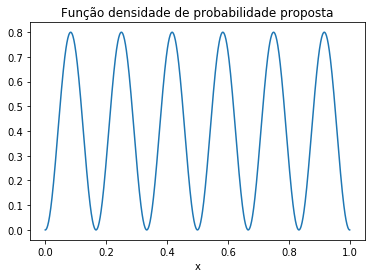

In [2]:
def f_(x):
    return np.select([x <= 0,(x > 0) & (x< 1), x>=1], [0, 0.8*(np.sin(6*np.pi*x))**2, 0])

plt.plot(np.linspace(0,1,1000),f_(np.linspace(0,1,1000)))
plt.title('Função densidade de probabilidade proposta')
plt.xlabel('x')
plt.show()

Neste caso, poderíamos fazer

$$ \int_0^1 0.8 \, \sin^2( 6\pi x ) dx = 0.4$$

e redefinir $f(x)$ de maneira normalizada como

$$ f(x) = 2 \, \sin^2( 6\pi x ) \, \mathbb{1}_{(0,1)}(x).$$

Mas mesmo com $f(x)$ normalizada não é obvio como criar amostras para $f$.

## Rejection Sampling

A ideia será criar pontos uniformemente em uma região e aceitar os pontos que caiem na região desejada.

In [3]:
def g_(x):
    return np.select([x <= 0,(x > 0) & (x< 1), x>=1], [0, 1, 0])

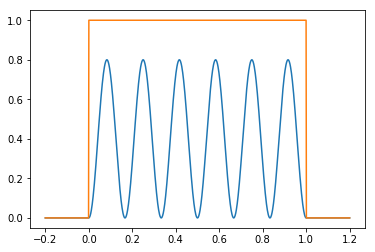

In [4]:
plt.plot(np.linspace(-0.2,1.2,1000),f_(np.linspace(-0.2,1.2,1000)))
plt.plot(np.linspace(-0.2,1.2,1000),g_(np.linspace(-0.2,1.2,1000)))

plt.show()

In [5]:
v1 = np.random.uniform(0,1,100)
v2 = np.random.uniform(0,1,100)

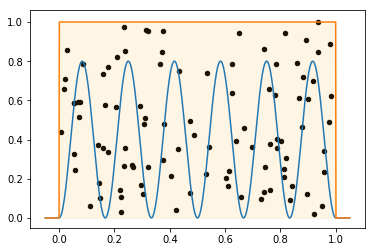

In [6]:
plt.scatter(v1,v2,s=20,c='k')
plt.plot(np.linspace(-0.05,1.05,1000),f_(np.linspace(-0.05,1.05,1000)))
plt.plot(np.linspace(-0.05,1.05,1000),g_(np.linspace(-0.05,1.05,1000)))
plt.fill_between(np.linspace(-0.05,1.05,1000), g_(np.linspace(-0.05,1.05,1000)),alpha=0.1,color='orange')
plt.show()

In [7]:
accept = v2<f_(v1)

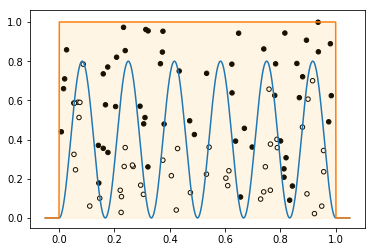

In [8]:
plt.scatter(v1,v2,s=20,c=accept,cmap='gray', edgecolors='k')
plt.plot(np.linspace(-0.05,1.05,1000),f_(np.linspace(-0.05,1.05,1000)))
plt.plot(np.linspace(-0.05,1.05,1000),g_(np.linspace(-0.05,1.05,1000)))
plt.fill_between(np.linspace(-0.05,1.05,1000), g_(np.linspace(-0.05,1.05,1000)),alpha=0.1,color='orange')
plt.show()

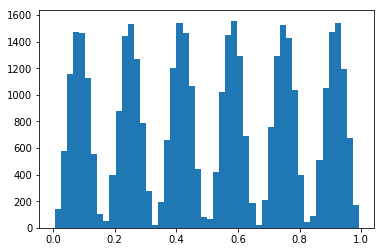

In [9]:
v1 = np.random.uniform(0,1,100000)
v2 = np.random.uniform(0,1,100000)
accept = v2<f_(v1)

plt.hist(v1[accept],bins=50)
plt.show()

## Problemas:

- Estamos jogando muitos caras fora porque a nossa região é "maior do que precisava ser".

In [10]:
sum(~accept)/len(accept)

0.59995

- Imagina que tenhamos um $f(x)$ que tenha suporte na reta inteira (como a gaussiana). Se eu limitar a fazer o sample só no quadrado eu não vou estar sendo realista com a distribuição de verdade de $f(x)$.

In [11]:
def f2_(x):
    return np.select([x <= 0, x>0], [0, norm(0, 0.5).pdf(x)])

def g2_(x):
    return np.select([x <= 0,(x > 0) & (x< 1.5), x>=1.5], [0, 1, 0])

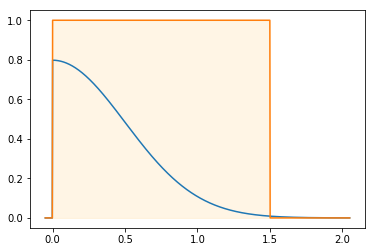

In [12]:
plt.plot(np.linspace(-0.05,2.05,1000),f2_(np.linspace(-0.05,2.05,1000)))
plt.plot(np.linspace(-0.05,2.05,1000),g2_(np.linspace(-0.05,2.05,1000)))
plt.fill_between(np.linspace(-0.05,2.05,1000), g2_(np.linspace(-0.05,2.05,1000)),alpha=0.1,color='orange')
plt.show()

A ideia agora é fazer a região ser o mais próxima possível da função real. Pra gente minimizar rejeições.

Precisamos usar distribuições que a gente conheça (saiba tirar amostras dela) e que tenham o formato adequado do que a gente tá tentando modelar.

In [13]:
def g3_(x):
    return np.select([x <= 0, x>0], [0, np.exp(-x)])


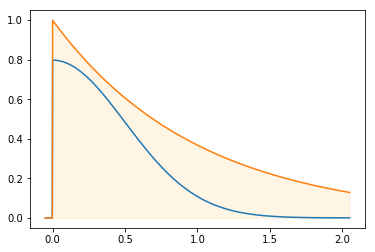

In [14]:
plt.plot(np.linspace(-0.05,2.05,1000),f2_(np.linspace(-0.05,2.05,1000)))
plt.plot(np.linspace(-0.05,2.05,1000),g3_(np.linspace(-0.05,2.05,1000)))
plt.fill_between(np.linspace(-0.05,2.05,1000), g3_(np.linspace(-0.05,2.05,1000)),alpha=0.1,color='orange')
plt.show()

Já está bem melhor, mas multiplicar por uma constante pode nos ajudar a evitar algumas dores de cabeça.

Se pegarmos

$$ M = \max \frac{f(x)}{g(x)}, $$

então $M\dot g(x)$ sempre é maior que $f(x)$ e além disso, elas ficam mais coladas.

Para estimar $M$ podemos fazer um early burning para explorar os valores possíveis de $x$ e daí escolher $M$ que maximiza nesses pontos explorados.

In [15]:
b = np.random.exponential(size=10)
M = np.max(f2_(b)/g3_(b))
M

0.8870502107180794

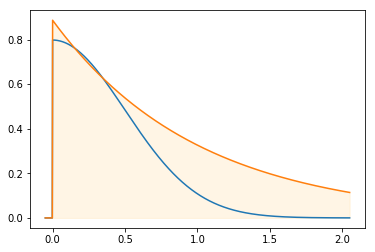

In [16]:
def g4_(x):
    return np.select([x <= 0, x>0], [0, M*np.exp(-x)])

plt.plot(np.linspace(-0.05,2.05,1000),f2_(np.linspace(-0.05,2.05,1000)))
plt.plot(np.linspace(-0.05,2.05,1000),g4_(np.linspace(-0.05,2.05,1000)))
plt.fill_between(np.linspace(-0.05,2.05,1000), g4_(np.linspace(-0.05,2.05,1000)),alpha=0.1,color='orange')
plt.show()

## Caso do exercício

In [17]:
def g(x):
    return norm(6,np.sqrt(10)).pdf(x)

def f(x):
    return 0.3*norm(3,1).pdf(x) + 0.7*norm(8,np.sqrt(4)).pdf(x)

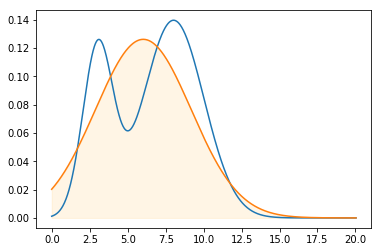

In [18]:
plt.plot(np.linspace(-0.05,20.05,1000),f(np.linspace(-0.05,20.05,1000)))
plt.plot(np.linspace(-0.05,20.05,1000),g(np.linspace(-0.05,20.05,1000)))
plt.fill_between(np.linspace(-0.05,20.05,1000), g(np.linspace(-0.05,20.05,1000)),alpha=0.1,color='orange')
plt.show()

In [19]:
b = np.random.normal(6,np.sqrt(10), size=1000)
M = np.max(f(b)/g(b))

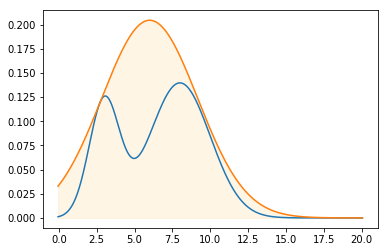

In [20]:
plt.plot(np.linspace(-0.05,20.05,1000),f(np.linspace(-0.05,20.05,1000)))
plt.plot(np.linspace(-0.05,20.05,1000),M*g(np.linspace(-0.05,20.05,1000)))
plt.fill_between(np.linspace(-0.05,20.05,1000), M*g(np.linspace(-0.05,20.05,1000)),alpha=0.1,color='orange')
plt.show()

In [22]:
sample = []
cont_reject = 0
while len(sample)<10000:
    u = np.random.uniform(0,1)
    z = np.random.normal(6,np.sqrt(10))
    if u < f(z)/(M*g(z)):
        sample.append(z)
    else:
        cont_reject +=1
    M = np.max([M, f(z)/g(z)])

In [24]:
cont_reject

6323

In [27]:
len(sample)

10000

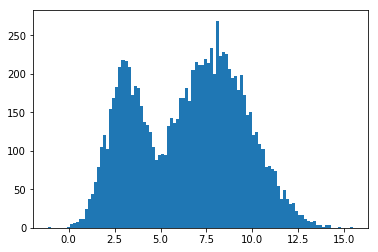

In [30]:
plt.hist(sample,bins=100)
plt.show()